
Prediction target: 
1.  Precise price

Features:
1. only previous close price
2. all data about the previous days
3. produce other features like max gap

Possible Models:
1. Linear Regression
2. LSTM
          
          

# Load and preprocess Data

## Load data and split into different commodity dataset

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# load the datset
df = pd.read_csv('/content/drive/MyDrive/FYP/commodity 2000-2022.csv')

# split the dataset following the different commodity
grouped = df.groupby(df.columns[0])
# use US Wheat data to test code first
US_Wheat = pd.DataFrame()
for name, group in grouped:
    if name == 'US Wheat':
        # drop the commodity name and date
        US_Wheat = group.drop(df.columns[0:2], axis=1)
US_Wheat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5824 entries, 24111 to 29934
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    5824 non-null   float64
 1   High    5824 non-null   float64
 2   Low     5824 non-null   float64
 3   Close   5824 non-null   float64
 4   Volume  5824 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 273.0 KB


## MinMax normalization for accelerate the optimization

In [ ]:
from sklearn.preprocessing import MinMaxScaler
def MinMax_normal(data):
    # MinMax normalization for accelerate the optimization
    # pretrain the scaler in range (0,1) since all data is price.
    sc = MinMaxScaler(feature_range = (0,1))
    # close_scaled = sc.fit_transform(Close_data)
    scaled_data = sc.fit_transform(data.values)
    return scaled_data

# use us wheat first
scaled_data = MinMax_normal(US_Wheat)

[[0.1858209  0.20074627 0.18379409 0.01908957 0.3188478 ]
 [0.1858209  0.18768657 0.18703527 0.01174743 0.01238771]]
0.0117474302496329


## visualization
visualize the basic colume from dataset

In [ ]:
def visualization():
    for name, group in grouped:
        fig, axs = plt.subplots(2, 1, figsize=(8, 8))
        axs[0].plot(group['Date'], group['Close'], label='{} Close'.format(name))
        axs[0].set_xlabel('Date')
        axs[0].set_ylabel('Close')
        axs[0].legend()

        axs[1].plot(group['Date'], group['Volume'], label='{} Volume'.format(name))
        axs[1].set_xlabel('Date')
        axs[1].set_ylabel('Volume')
        axs[1].legend()

        plt.show()
        
        return

# Use linear regression
linearing machine learning model

(5824, 5)
Random splited data


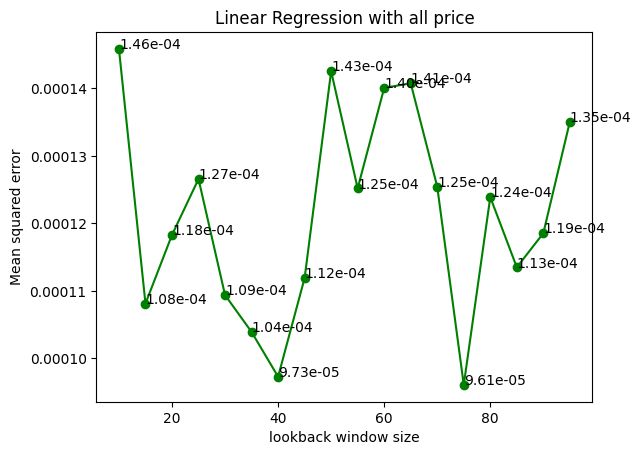

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# split data with different lookback and shuffle or not.
# return X_train, X_test, y_train, y_test
def data_split(lookback,scaled_data,random_Split=True):
    # Initialize empty lists for X and y data
    x = []
    y = []
    for i in range(lookback,len(scaled_data)):
        x.append(scaled_data[i-lookback:i, 3])
        y.append(scaled_data[i, 3])
    # convert list to numpy array
    x,y = np.array(x),np.array(y)
    if random_Split:
        # Split and return 
        return train_test_split(x, y, test_size=0.2, random_state=42)
    else:
        # Split and return 
        return train_test_split(x, y, test_size=0.2, shuffle = False)

# use a lookback window including the previous close to predict the new close
# return the MSE,X_test,y_test,lr_model
def LinearRegression_lookback(lookback,scaled_data,random_Split):
    # Split test and train dataset
    X_train, X_test, y_train, y_test = data_split(lookback,scaled_data,random_Split)
    
    # build the linear regression model
    lr_model = LinearRegression()
    
    # train
    lr_model.fit(X_train, y_train)

    # predict
    y_pred = lr_model.predict(X_test)
    
    # compute the mse for evaluate
    mse = mean_squared_error(y_test, y_pred)

    return mse,X_test,y_test,lr_model

# store the mse in list for visualiazation
# return two mse list
def mseList(lookbacks,scaled_data,shuffle = True):
    mse_list = []
    for lookback in lookbacks:
        mse,_,_,_ = LinearRegression_lookback(lookback,scaled_data,shuffle)
        mse_list.append(mse)
    return mse_list

# evaluation and visualiazation 
# output two plots 
def visual(lookbacks,mse_list):
    # plot the mse for all prices
    plt.plot(lookbacks, mse_list, color = 'g', marker ='o', label = 'All price')
    plt.title('Linear Regression with all price')
    plt.xlabel('lookback window size')
    plt.ylabel('Mean squared error')
    # add values for every point
    for i, j in zip(lookbacks, mse_list):
        plt.text(i, j, "{:.2e}".format(j))
    # show plot
    plt.show()
    return

# define the parameter$lookback
lookbacks = np.arange(10, 100, 5)
print(scaled_data.shape)
#train and get the mse using the random splited data
mse_list = mseList(lookbacks,scaled_data)
# evaluation and visualiazation for random splited data
print('Random splited data')
visual(lookbacks,mse_list)



## Check the performance for specific situation

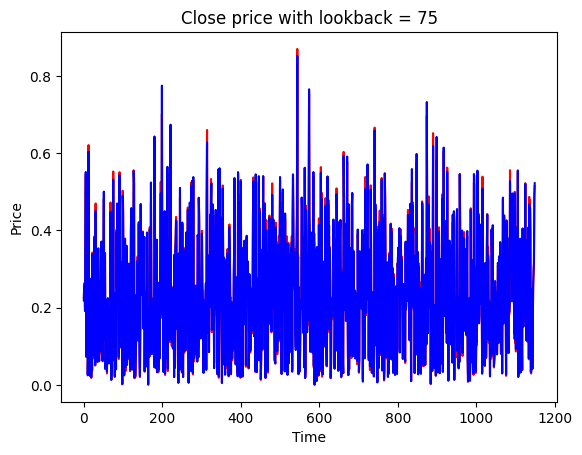

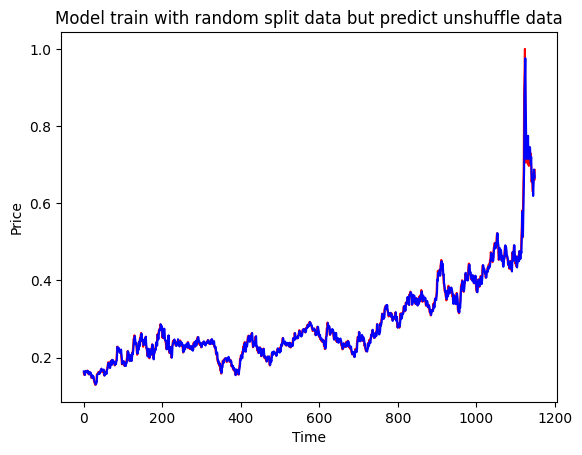

In [ ]:
# best performance for random split: Close price with lookback = 75
_,X_test_1,y_test_1,lr_model_1 = LinearRegression_lookback(75,scaled_data,True)
x1 = range(len(X_test_1))
# get prediction
y_pred_1 = lr_model_1.predict(X_test_1)
# plot true price and prediction
plt.plot(x1, y_test_1,color = 'r',label = 'Real price')
plt.plot(x1, y_pred_1,color = 'b',label = 'prediction')
plt.title("Close price with lookback = 75")
plt.xlabel("Time")
plt.ylabel("Price")
plt.show()

# # best performance for split without shuffle: All price with lookback = 10
# _,X_test_2,y_test_2,lr_model_2 = LinearRegression_lookback(10,all_scaled,False)
# x2 = range(len(X_test_2))
# # get prediction
# y_pred_2 = lr_model_2.predict(X_test_2)
# # plot true price and prediction
# plt.plot(x2, y_test_2,color = 'r',label = 'Real price')
# plt.plot(x2, y_pred_2,color = 'b',label = 'prediction')
# plt.title("All price with lookback = 10")
# plt.xlabel("Time")
# plt.ylabel("Price")
# plt.show()

# check the performance for model train with random split data but predict following the data without shuffle
_,X_test_3,y_test_3,_ = LinearRegression_lookback(75,scaled_data,False)
x3 = range(len(X_test_3))
# get prediction
y_pred_3 = lr_model_1.predict(X_test_3)
# plot true price and prediction
plt.plot(x3, y_test_3,color = 'r',label = 'Real price')
plt.plot(x3, y_pred_3,color = 'b',label = 'prediction')
plt.title("Model train with random split data but predict unshuffle data")
plt.xlabel("Time")
plt.ylabel("Price")
plt.show()
    

## Build linear regression for other commodity

For commodity Brent Oil, the MSE about close price and all price:


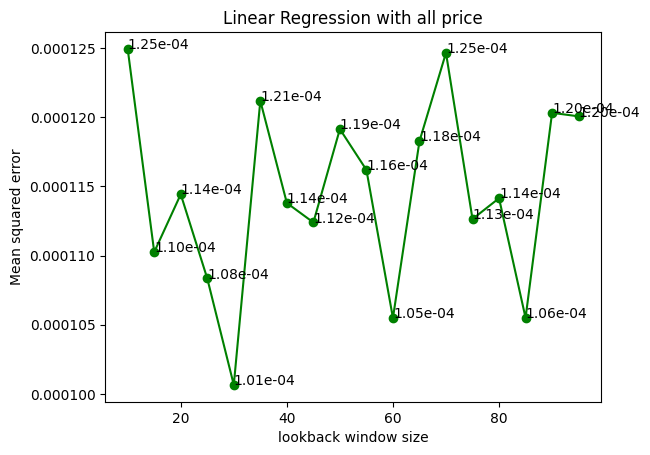

For commodity Gold, the MSE about close price and all price:


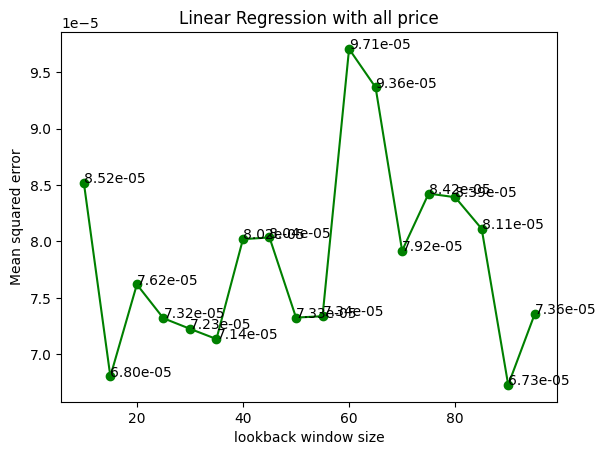

For commodity Natural Gas, the MSE about close price and all price:


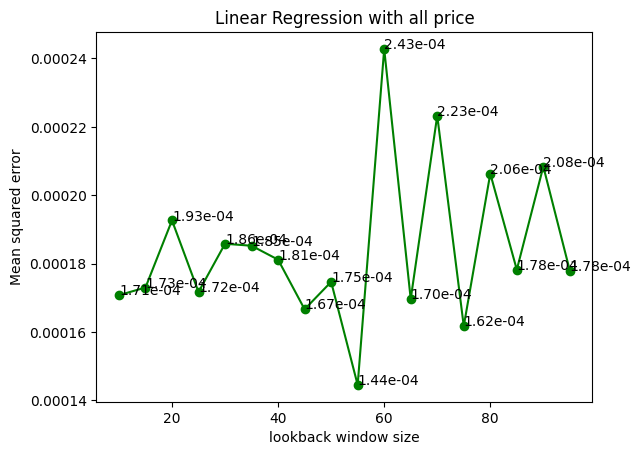

For commodity Nickel, the MSE about close price and all price:


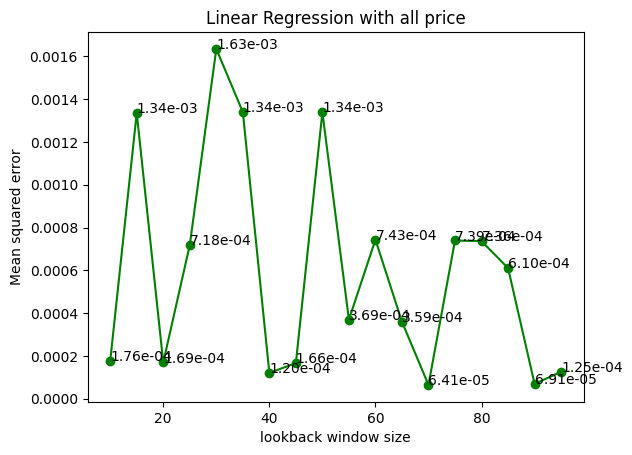

For commodity Palladium, the MSE about close price and all price:


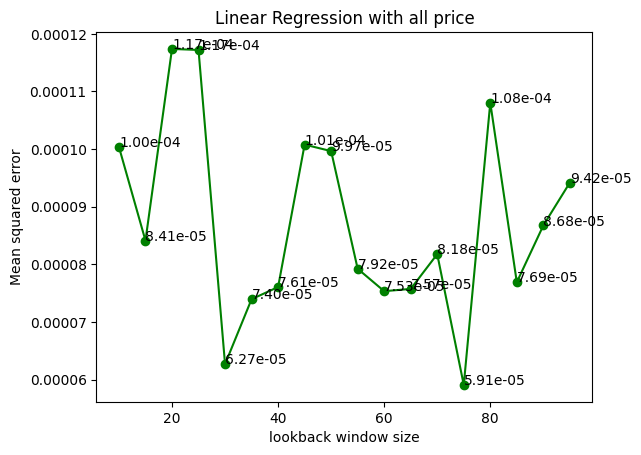

For commodity US Wheat, the MSE about close price and all price:


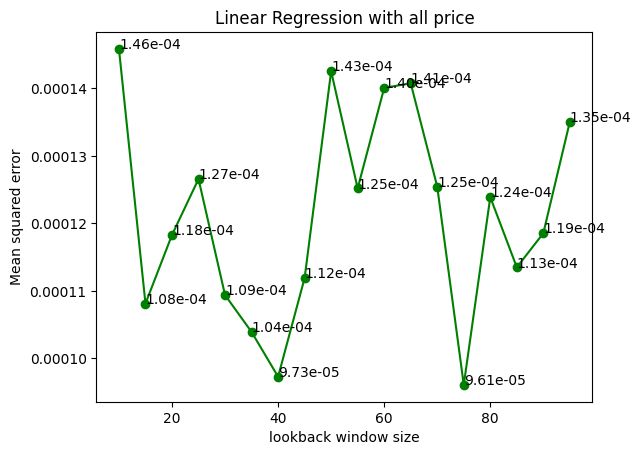

In [ ]:
for name, group in grouped:
    data = group.drop(df.columns[0:2], axis=1)
    scaled_data= MinMax_normal(data)

    #train and get the mse using the random splited data
    mse_list = mseList(lookbacks,scaled_data)
    # evaluation and visualiazation for random splited data
    print('For commodity {}, the MSE about close price and all price:'.format(name))
    visual(lookbacks,mse_list)

# Use LSTM (long short time memory)
deep-learning model

## Pre-define functions

In [8]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor

def data_split2(lookback,scaled_data,random_Split=True):
    # Initialize empty lists for X and y data
    x = []
    y = []
    for i in range(lookback,len(scaled_data)):
        x.append(scaled_data[i-lookback:i])
        y.append(scaled_data[i,3])
    # convert list to numpy array
    x,y = np.array(x),np.array(y)
    if random_Split:
        # Split and return 
        return train_test_split(x, y, test_size=0.2, random_state=42)
    else:
        # Split and return 
        return train_test_split(x, y, test_size=0.2, shuffle = False)


def LSTM_model(layer_num,units_num,dropOut_rate,input_shape):
    # define and build model as instruction
    model = Sequential()
    for i in range(layer_num):
        # first layer
        if i == 0:
            model.add(LSTM(units_num, input_shape=input_shape, return_sequences=True))
            model.add(Dropout(dropOut_rate))
        # last layer
        elif i == layer_num - 1:
            model.add(LSTM(units_num, return_sequences=False))
            model.add(Dropout(dropOut_rate))
        # middle layer
        else:
            model.add(LSTM(units_num, return_sequences=True))
            model.add(Dropout(dropOut_rate))
    model.add(Dense(units = 1))
    model.compile(optimizer = 'adam',loss = 'mean_squared_error')
    return model


## Build the model and GridSearch for the best parameters

Fitting 3 folds for each of 27 candidates, totalling 81 fits


<ipython-input-8-9bdecd4deb81>:19: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=LSTM_model, verbose=0)
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


The best paramters are {'dropOut_rate': 0.2, 'input_shape': (10, 5), 'layer_num': 3, 'units_num': 150} with lookback = 10
37/37 [==============================] - 1s 3ms/step
Fitting 3 folds for each of 27 candidates, totalling 81 fits


<ipython-input-8-9bdecd4deb81>:19: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=LSTM_model, verbose=0)
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


The best paramters are {'dropOut_rate': 0.1, 'input_shape': (20, 5), 'layer_num': 3, 'units_num': 100} with lookback = 20
37/37 [==============================] - 1s 4ms/step
Fitting 3 folds for each of 27 candidates, totalling 81 fits


<ipython-input-8-9bdecd4deb81>:19: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=LSTM_model, verbose=0)
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


The best paramters are {'dropOut_rate': 0.1, 'input_shape': (30, 5), 'layer_num': 3, 'units_num': 150} with lookback = 30
37/37 [==============================] - 1s 5ms/step
Fitting 3 folds for each of 27 candidates, totalling 81 fits


<ipython-input-8-9bdecd4deb81>:19: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=LSTM_model, verbose=0)
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


The best paramters are {'dropOut_rate': 0.1, 'input_shape': (40, 5), 'layer_num': 3, 'units_num': 100} with lookback = 40
37/37 [==============================] - 1s 4ms/step
Fitting 3 folds for each of 27 candidates, totalling 81 fits


<ipython-input-8-9bdecd4deb81>:19: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=LSTM_model, verbose=0)
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


The best paramters are {'dropOut_rate': 0.1, 'input_shape': (50, 5), 'layer_num': 2, 'units_num': 150} with lookback = 50
37/37 [==============================] - 1s 4ms/step
Fitting 3 folds for each of 27 candidates, totalling 81 fits


<ipython-input-8-9bdecd4deb81>:19: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=LSTM_model, verbose=0)
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


The best paramters are {'dropOut_rate': 0.1, 'input_shape': (60, 5), 'layer_num': 3, 'units_num': 100} with lookback = 60
37/37 [==============================] - 1s 5ms/step
Fitting 3 folds for each of 27 candidates, totalling 81 fits


<ipython-input-8-9bdecd4deb81>:19: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=LSTM_model, verbose=0)
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


The best paramters are {'dropOut_rate': 0.1, 'input_shape': (70, 5), 'layer_num': 2, 'units_num': 150} with lookback = 70
36/36 [==============================] - 1s 4ms/step
Fitting 3 folds for each of 27 candidates, totalling 81 fits


<ipython-input-8-9bdecd4deb81>:19: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=LSTM_model, verbose=0)
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


The best paramters are {'dropOut_rate': 0.1, 'input_shape': (80, 5), 'layer_num': 2, 'units_num': 150} with lookback = 80
36/36 [==============================] - 1s 6ms/step
Fitting 3 folds for each of 27 candidates, totalling 81 fits


<ipython-input-8-9bdecd4deb81>:19: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=LSTM_model, verbose=0)
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


The best paramters are {'dropOut_rate': 0.1, 'input_shape': (90, 5), 'layer_num': 3, 'units_num': 150} with lookback = 90
36/36 [==============================] - 1s 7ms/step


Text(0, 0.5, 'Mean Squared Error')

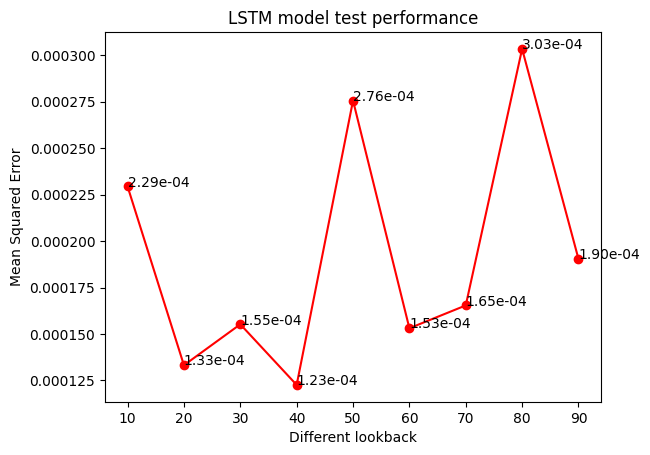

In [ ]:
# for data split
lookbacks = np.arange(10, 100, 10)

# use only close price to train the model with diferent lookback
mse_list = []
for lookback in lookbacks:
    # randomly split dataset 
    X_train, X_test, y_train, y_test = data_split2(lookback,scaled_data,True)
    # define the hyperparameter space
    param_grid = {
        'layer_num':[2,3,4],
        'units_num':[50,100,150],
        'dropOut_rate':[0.1,0.2,0.5],
        'input_shape':[(X_train.shape[1], X_train.shape[2])]
    }
    # define training setting
    n_epochs = 30
    batch_size = 32
    model = KerasRegressor(build_fn=LSTM_model, verbose=0)
    # creat GridSearch objects
    grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
    # run GridSearch
    grid.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size)
    # predict with best model
    print('The best paramters are {} with lookback = {}'.format(grid.best_params_,lookback))
    best_model = grid.best_estimator_.model
    y_pred = best_model.predict(X_test)
    mse_list.append(mean_squared_error(y_test, y_pred))

# plot model performance in every epoch
plt.plot(lookbacks,mse_list,color = 'red', marker ='o')
for i, j in zip(lookbacks, mse_list):
    plt.text(i, j, "{:.2e}".format(j))
plt.title('LSTM model test performance')
plt.xlabel('Different lookback')
plt.ylabel('Mean Squared Error')

# Use support vector regression (SVR) 
Non-learning machine learning model

The best paramters are {'C': 10, 'gamma': 1} with lookback = 10
The best paramters are {'C': 100, 'gamma': 0.1} with lookback = 15
The best paramters are {'C': 100, 'gamma': 0.1} with lookback = 20
The best paramters are {'C': 100, 'gamma': 0.1} with lookback = 25
The best paramters are {'C': 0.1, 'gamma': 0.1} with lookback = 30
The best paramters are {'C': 100, 'gamma': 0.1} with lookback = 35
The best paramters are {'C': 100, 'gamma': 0.1} with lookback = 40
The best paramters are {'C': 0.1, 'gamma': 0.1} with lookback = 45
The best paramters are {'C': 0.1, 'gamma': 0.1} with lookback = 50
The best paramters are {'C': 0.1, 'gamma': 0.1} with lookback = 55
The best paramters are {'C': 0.1, 'gamma': 0.1} with lookback = 60
The best paramters are {'C': 0.1, 'gamma': 0.1} with lookback = 65
The best paramters are {'C': 0.1, 'gamma': 0.1} with lookback = 70
The best paramters are {'C': 0.1, 'gamma': 0.1} with lookback = 75
The best paramters are {'C': 0.1, 'gamma': 0.1} with lookback = 8

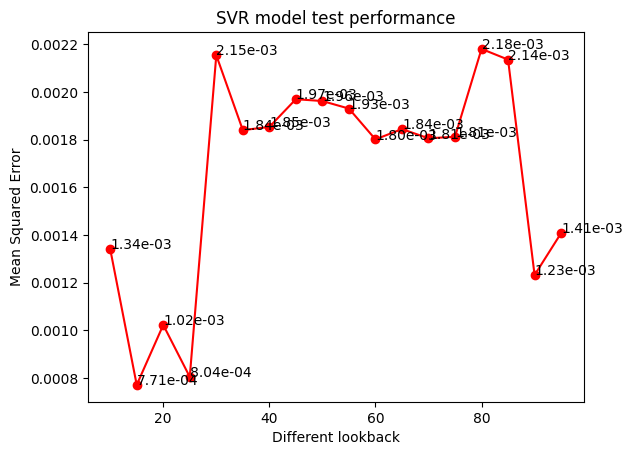

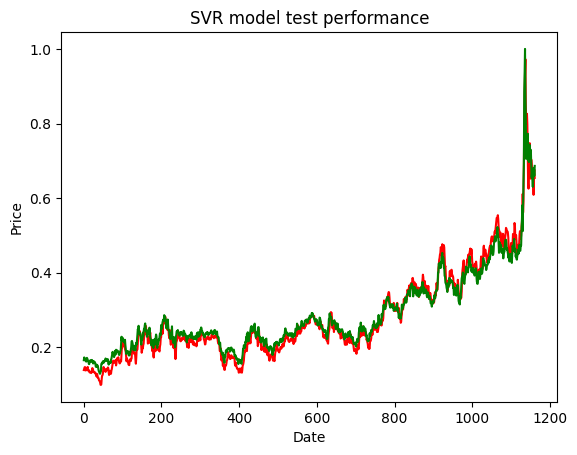

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

# define the hyperparameters for grid search
params = {
    # degree control low c-> wider margin
    'C': [0.1, 1, 10, 100],
    # controls the shape of the decision boundary bigger gamma -> more irregular
    'gamma': [0.001, 0.01, 0.1, 1]
}
# use the data-split function for linear regression.
mse_list = []
lookbacks = np.arange(10, 100, 5)
best_mse = float('inf')
for lookback in lookbacks:
    X_train, X_test, y_train, y_test = data_split(lookback,scaled_data)

    # perform grid search cross-validation
    svr = GridSearchCV(SVR(kernel='rbf'), param_grid=params, cv=5)
    svr.fit(X_train, y_train)

    # print the best hyperparameters and score
    print('The best paramters are {} with lookback = {}'.format(svr.best_params_,lookback))
    best_model = svr.best_estimator_
    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mse_list.append(mse)

    if mse <= best_mse:
        final_model = best_model
        best_lookback = lookback
        best_mse = mse
    

# plot model performance by mse 
plt.plot(lookbacks,mse_list,color = 'red', marker ='o')
for i, j in zip(lookbacks, mse_list):
    plt.text(i, j, "{:.2e}".format(j))
plt.title('SVR model test performance')
plt.xlabel('Different lookback')
plt.ylabel('Mean Squared Error')
plt.show()

# plot model performance by true label and pridection
X_train, X_test, y_train, y_test = data_split(best_lookback,scaled_data,False)
x = range(len(X_test))
y_pred = final_model.predict(X_test)
plt.plot(x,y_pred,color = 'red',label = 'Prediction')
plt.plot(x,y_test,color = 'green',label = 'Real price')
plt.title('SVR model test performance')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

# Does more indicators will improve the LSTM performance.

## Get more indicator

In [9]:
# extract several technical indicators

# compute the moving average as new technical indicator
US_Wheat['7_day_ma'] = US_Wheat['Close'].rolling(window=7).mean()

# Compute the RSI

# Compute the daily returns
US_Wheat['Return'] = US_Wheat['Close'].diff()
# Compute the gain and loss for each day
US_Wheat['Gain'] = US_Wheat['Return'].apply(lambda x: x if x > 0 else 0)
US_Wheat['Loss'] = US_Wheat['Return'].apply(lambda x: abs(x) if x < 0 else 0)
# Compute the average gain and average loss for the last 14 days
US_Wheat['AvgGain'] = US_Wheat['Gain'].rolling(window = 14).mean()
US_Wheat['AvgLoss'] = US_Wheat['Loss'].rolling(window = 14).mean()
# Compute the Relative Strength (RS)
US_Wheat['RS'] = US_Wheat['AvgGain'] / US_Wheat['AvgLoss']
# Compute the RSI
US_Wheat['RSI'] = 100 - (100 / (1 + US_Wheat['RS']))

# use first 13 rows to generate the feature
more_indcators = US_Wheat[13:]

# MinMax normalization
scaled_data = MinMax_normal(more_indcators)

## Find a best LSTM and its performance with new indicators

Fitting 3 folds for each of 27 candidates, totalling 81 fits


<ipython-input-10-e89ed441e09c>:19: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=LSTM_model, verbose=0)
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


The best paramters are {'dropOut_rate': 0.1, 'input_shape': (10, 13), 'layer_num': 2, 'units_num': 150} with lookback = 10
37/37 [==============================] - 1s 3ms/step
Fitting 3 folds for each of 27 candidates, totalling 81 fits


<ipython-input-10-e89ed441e09c>:19: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=LSTM_model, verbose=0)
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


The best paramters are {'dropOut_rate': 0.2, 'input_shape': (20, 13), 'layer_num': 2, 'units_num': 100} with lookback = 20
37/37 [==============================] - 1s 3ms/step
Fitting 3 folds for each of 27 candidates, totalling 81 fits


<ipython-input-10-e89ed441e09c>:19: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=LSTM_model, verbose=0)
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


The best paramters are {'dropOut_rate': 0.2, 'input_shape': (30, 13), 'layer_num': 2, 'units_num': 150} with lookback = 30
37/37 [==============================] - 1s 3ms/step
Fitting 3 folds for each of 27 candidates, totalling 81 fits


<ipython-input-10-e89ed441e09c>:19: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=LSTM_model, verbose=0)
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


The best paramters are {'dropOut_rate': 0.1, 'input_shape': (40, 13), 'layer_num': 3, 'units_num': 150} with lookback = 40
37/37 [==============================] - 1s 4ms/step
Fitting 3 folds for each of 27 candidates, totalling 81 fits


<ipython-input-10-e89ed441e09c>:19: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=LSTM_model, verbose=0)
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


The best paramters are {'dropOut_rate': 0.1, 'input_shape': (50, 13), 'layer_num': 2, 'units_num': 100} with lookback = 50
37/37 [==============================] - 1s 3ms/step
Fitting 3 folds for each of 27 candidates, totalling 81 fits


<ipython-input-10-e89ed441e09c>:19: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=LSTM_model, verbose=0)
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


The best paramters are {'dropOut_rate': 0.2, 'input_shape': (60, 13), 'layer_num': 2, 'units_num': 100} with lookback = 60
36/36 [==============================] - 1s 4ms/step
Fitting 3 folds for each of 27 candidates, totalling 81 fits


<ipython-input-10-e89ed441e09c>:19: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=LSTM_model, verbose=0)
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


The best paramters are {'dropOut_rate': 0.2, 'input_shape': (70, 13), 'layer_num': 2, 'units_num': 100} with lookback = 70
36/36 [==============================] - 1s 4ms/step
Fitting 3 folds for each of 27 candidates, totalling 81 fits


<ipython-input-10-e89ed441e09c>:19: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=LSTM_model, verbose=0)
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


The best paramters are {'dropOut_rate': 0.1, 'input_shape': (80, 13), 'layer_num': 2, 'units_num': 150} with lookback = 80
36/36 [==============================] - 1s 4ms/step
Fitting 3 folds for each of 27 candidates, totalling 81 fits


<ipython-input-10-e89ed441e09c>:19: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=LSTM_model, verbose=0)
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


The best paramters are {'dropOut_rate': 0.2, 'input_shape': (90, 13), 'layer_num': 2, 'units_num': 100} with lookback = 90
36/36 [==============================] - 1s 4ms/step


Text(0, 0.5, 'Mean Squared Error')

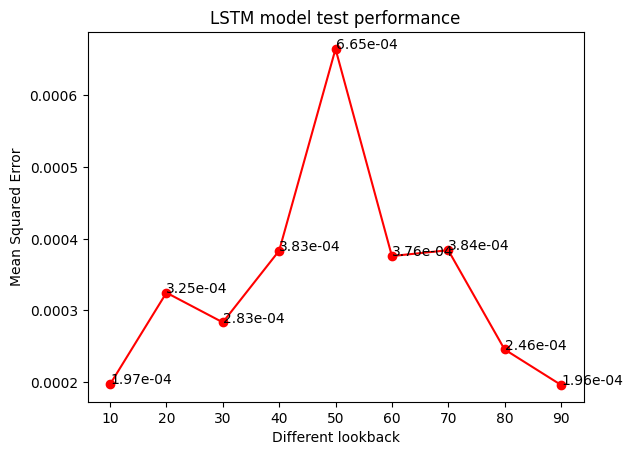

In [10]:
# for data split
lookbacks = np.arange(10, 100, 10)

# use only close price to train the model with diferent lookback
mse_list = []
for lookback in lookbacks:
    # randomly split dataset 
    X_train, X_test, y_train, y_test = data_split2(lookback,scaled_data,False)
    # define the hyperparameter space
    param_grid = {
        'layer_num':[2,3,4],
        'units_num':[50,100,150],
        'dropOut_rate':[0.1,0.2,0.5],
        'input_shape':[(X_train.shape[1], X_train.shape[2])]
    }
    # define training setting
    n_epochs = 10
    batch_size = 32
    model = KerasRegressor(build_fn=LSTM_model, verbose=0)
    # creat GridSearch objects
    grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
    # run GridSearch
    grid.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size)
    # predict with best model
    print('The best paramters are {} with lookback = {}'.format(grid.best_params_,lookback))
    best_model = grid.best_estimator_.model
    y_pred = best_model.predict(X_test)
    mse_list.append(mean_squared_error(y_test, y_pred))

# plot model performance in every epoch
plt.plot(lookbacks,mse_list,color = 'red', marker ='o')
for i, j in zip(lookbacks, mse_list):
    plt.text(i, j, "{:.2e}".format(j))
plt.title('LSTM model test performance')
plt.xlabel('Different lookback')
plt.ylabel('Mean Squared Error')


# CNN+LSTM

Epoch 1/50
145/145 [==============================] - 9s 8ms/step - loss: 0.0041
Epoch 2/50
145/145 [==============================] - 1s 8ms/step - loss: 8.1837e-04
Epoch 3/50
145/145 [==============================] - 1s 8ms/step - loss: 6.7260e-04
Epoch 4/50
145/145 [==============================] - 1s 8ms/step - loss: 5.3181e-04
Epoch 5/50
145/145 [==============================] - 1s 8ms/step - loss: 4.3443e-04
Epoch 6/50
145/145 [==============================] - 1s 9ms/step - loss: 3.8089e-04
Epoch 7/50
145/145 [==============================] - 2s 12ms/step - loss: 3.7659e-04
Epoch 8/50
145/145 [==============================] - 2s 11ms/step - loss: 5.1325e-04
Epoch 9/50
145/145 [==============================] - 1s 8ms/step - loss: 3.4317e-04
Epoch 10/50
145/145 [==============================] - 1s 9ms/step - loss: 4.6517e-04
Epoch 11/50
145/145 [==============================] - 1s 8ms/step - loss: 3.5878e-04
Epoch 12/50
145/145 [==============================] - 1s 8ms/ste

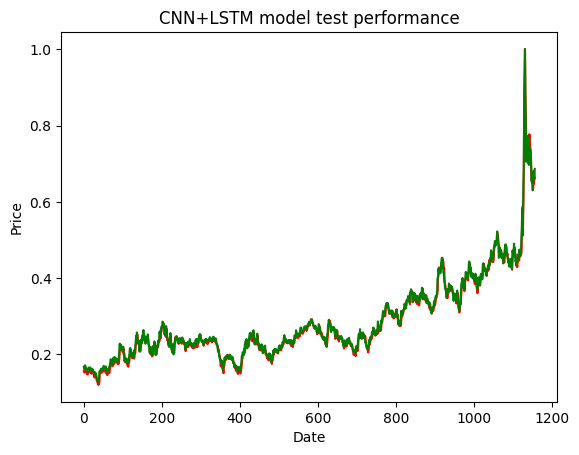

In [ ]:
from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, Input, Concatenate, Reshape
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Flatten, Dropout
import numpy as np
import tensorflow as tf

# Define the input dimensions for three time-frame
dims = np.arange(10, 40, 10)

# # Define the LSTM units and dropout rate
# lstm_units = 64
# dropout_rate = 0.2

def data_split3(dims,scaled_data,random_Split=True):
    # Initialize empty lists for X and y data
    all_x = []
    for i in enumerate(dims):
      all_x.append([])
    y = []

    for i in range(dims[2],len(scaled_data)):
        for index, dim in enumerate(dims):
            all_x[index].append(scaled_data[i-dim:i])
        y.append(scaled_data[i,3])

    y = np.array(y)

    # Split and return 
    all_x_train = []
    all_x_test = []
    if random_Split:
        for x in all_x:
            X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
            all_x_train.append(X_train)
            all_x_test.append(X_test)
    else:
        for x in all_x:
            X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2,shuffle = False)
            all_x_train.append(X_train)
            all_x_test.append(X_test)

    # convert the list of list of array to list of array of array
    x_train_array = []
    for x in all_x_train: 
      array_x = np.array(x)
      x_train_array.append(array_x)
    x_test_array = []
    for x in all_x_test: 
        x_test_array.append(np.array(x))

    return x_train_array,x_test_array, y_train, y_test

# get the splited data for model
x_train_array,x_test_array, y_train, y_test = data_split3(dims,scaled_data,random_Split=True)

# get the input size for every time frame
inputs_shapes =[]

for x in x_train_array: 
    inputs_shapes.append(x[1].shape)

# Define the CNN layers for each time frame
def create_cnn_model(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.compile(optimizer='adam',loss = 'mse')
    return model

cnn_models = []
for input_shape in inputs_shapes:
  cnn_models.append(create_cnn_model(input_shape))

# Combine the outputs of the CNN models
concatenated_outputs = Concatenate(axis=1)([model.output for model in cnn_models])
concatenated_outputs = Reshape((1, -1))(concatenated_outputs)

# feed the features CNN got into a LSTM layer
lstm_layer = LSTM(units=100, return_sequences=True)(concatenated_outputs)
lstm_layer = Dropout(0.1)(lstm_layer)
lstm_layer = LSTM(units=100, return_sequences=False)(lstm_layer)
lstm_layer = Dropout(0.1)(lstm_layer)
output = Dense(1)(lstm_layer)

# create the combined final model
merged_model = Model(inputs=[model.layers[0].input for model in cnn_models], outputs=output)
merged_model.compile(optimizer='adam', loss='mse')

# train the combined model
merged_model.fit(x_train_array, y_train, epochs=50, batch_size=32)

# plot model performance by true label and pridection
x_train_array,x_test_array, y_train, y_test = data_split3(dims,scaled_data,False)
x = range(len(y_test))
y_pred = merged_model.predict(x_test_array)
print("The mean squared error is {:.2e}".format(mean_squared_error(y_test, y_pred)))
plt.plot(x,y_pred,color = 'red',label = 'Prediction')
plt.plot(x,y_test,color = 'green',label = 'Real price')
plt.title('CNN+LSTM model test performance')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()
